# Imports and Functions

In [1]:
import requests
requests.packages.urllib3.disable_warnings()
import json
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from ternarpy import *
import pandas as pd
import pprint
import numpy

In [2]:
def check_response(r,quiet=False):
    try:
        r_content = r.json(object_pairs_hook=OrderedDict)
    except:
        r_content = r.text
    if str(r.status_code)[0] is not "2":
        if not quiet: print("Error: ",r.status_code) 
        if not quiet: print(r.text)
    else:
        return r_content

In [3]:
def mdcs_query(host,query,format='json'):
    url = host.strip("/") + "/rest/explore/query-by-example"
    data = dict()
    data['query'] = query
    data['dataformat'] = format
    r = requests.post(url, data=data, verify=False) # This needs to be fixed
    return check_response(r)

# Get the data

This may break in the future if future round robin datasets are added, which would require more specific queries.

In [4]:
host = "https://hte.registry.nist.gov/"
query = '{"content.library.keyword":"round robin"}'
query_response = mdcs_query(host,query)

In [5]:
libraries = dict()
id_list = dict()
id_list['s_nist_c_nist'] = list()
id_list['s_nist_c_nrel'] = list()
id_list['s_nrel_c_nist'] = list()
id_list['s_nrel_c_nrel'] = list()
flip = {'a':'b','b':'a'}
library_pairs = dict()
for record in query_response:
    lib_id = record['content']['library']['identifier'][0]['id']
    org = record['content']['library']['associated']['organization']['altName']
    comment = record['content']['library']['comment']
    libraries[lib_id] = record['content']['library']
    if 'NIST' in comment:
        nist_id = lib_id
        end_char = nist_id[-1]
        nrel_id = nist_id[0:-1]+flip[end_char]
        library_pairs[nist_id] = nrel_id
        library_pairs[nrel_id] = nist_id
    
    if 'NIST' in org and 'NIST' in comment:
        id_list['s_nist_c_nist'].append(lib_id)
    if 'NIST' in org and 'NREL' in comment:
        id_list['s_nist_c_nrel'].append(lib_id)
    if 'NREL' in org and 'NIST' in comment:
        id_list['s_nrel_c_nist'].append(lib_id)
    if 'NREL' in org and 'NREL' in comment:
        id_list['s_nrel_c_nrel'].append(lib_id)

print(id_list['s_nist_c_nist'])
print(id_list['s_nist_c_nrel'])
print(id_list['s_nrel_c_nist'])
print(id_list['s_nrel_c_nrel'])

print(library_pairs)

['20.500.12048/lib.2015.1a']
['20.500.12048/lib.2015.1b']
['20.500.12048/lib.2016.1b', '20.500.12048/lib.2016.2b', '20.500.12048/lib.2016.3b']
['20.500.12048/lib.2016.1a', '20.500.12048/lib.2016.2a', '20.500.12048/lib.2016.3a']
{'20.500.12048/lib.2015.1a': '20.500.12048/lib.2015.1b', '20.500.12048/lib.2015.1b': '20.500.12048/lib.2015.1a', '20.500.12048/lib.2016.1b': '20.500.12048/lib.2016.1a', '20.500.12048/lib.2016.1a': '20.500.12048/lib.2016.1b', '20.500.12048/lib.2016.2b': '20.500.12048/lib.2016.2a', '20.500.12048/lib.2016.2a': '20.500.12048/lib.2016.2b', '20.500.12048/lib.2016.3b': '20.500.12048/lib.2016.3a', '20.500.12048/lib.2016.3a': '20.500.12048/lib.2016.3b'}


# Parse Data

In [6]:
data_list = dict()
data_list['s_nist_c_nist'] = list()
data_list['s_nist_c_nrel'] = list()
data_list['s_nrel_c_nist'] = list()
data_list['s_nrel_c_nrel'] = list()
columns = list()
set_column_element = True
set_column_property = True
for group,members in id_list.items():
    print(group)
    for lib_id in members:
        print("\t"+lib_id)
        for sample_num,sample in enumerate(libraries[lib_id]['sample']):
            item = list()
            try:
                for c in sample['composition']['constituent']:
                    if set_column_element:
                        columns.append(c['chemical-formula'])
                    try:
                        item.append(c['quantity'])
                    except:
                        item.append(0.0)
            except:
                sibling_sample = libraries[library_pairs[lib_id]]['sample'][sample_num]
                for c in sibling_sample['composition']['constituent']:
                    try:
                        item.append(c['quantity'])
                    except:
                        item.append(0.0)
            for p in sample['property']:
                if set_column_property:
                    columns.append(p['name'])
                try:
                    item.append(p['value'])
                except:
                    item.append(0.0)
            set_column_element = False
            set_column_property = False
            data_list[group].append(item)

s_nist_c_nist
	20.500.12048/lib.2015.1a
s_nist_c_nrel
	20.500.12048/lib.2015.1b
s_nrel_c_nist
	20.500.12048/lib.2016.1b
	20.500.12048/lib.2016.2b
	20.500.12048/lib.2016.3b
s_nrel_c_nrel
	20.500.12048/lib.2016.1a
	20.500.12048/lib.2016.2a
	20.500.12048/lib.2016.3a


In [7]:
columns

['Zn',
 'Sn',
 'Ti',
 'O',
 'film thickness',
 'conductivity',
 'sheet resistance',
 'band gap']

# Plot Band Gap

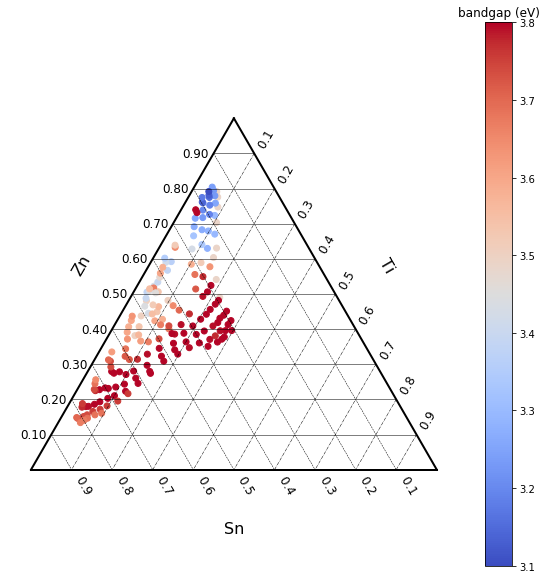

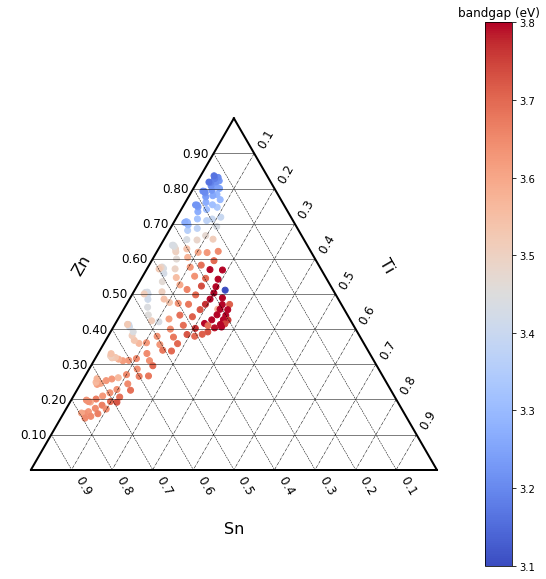

In [8]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[columns[0:3]].as_matrix()
nrel_X = nrel_df[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['band gap'], cmap='coolwarm', vmin=3.1, vmax=3.8);
plt.colorbar(points).ax.set_title('bandgap (eV)')
plt.savefig("band-gap-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['band gap'], cmap='coolwarm', vmin=3.1, vmax=3.8);
plt.colorbar(points).ax.set_title('bandgap (eV)')
plt.savefig("band-gap-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[columns[0:3]].as_matrix()
nrel_X = nrel_df[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['band gap'], cmap='coolwarm', vmin=2.5, vmax=3.2);
plt.colorbar(points).ax.set_title('bandgap (eV)')
plt.savefig("band-gap-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['band gap'], cmap='coolwarm', vmin=2.5, vmax=3.2);
plt.colorbar(points).ax.set_title('bandgap (eV)')
plt.savefig("band-gap-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

# Plot Thickness

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[columns[0:3]].as_matrix()
nrel_X = nrel_df[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['film thickness'], cmap='coolwarm', vmin=60, vmax=110);
plt.colorbar(points).ax.set_title('Thickness (nm)')
plt.savefig("thickness-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['film thickness'], cmap='coolwarm', vmin=60, vmax=110);
plt.colorbar(points).ax.set_title('Thickness (nm)')
plt.savefig("thickness-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
basis = make_basis()
nist_X = nist_df[columns[0:3]].as_matrix()
nrel_X = nrel_df[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=nist_df['film thickness'], cmap='coolwarm', vmin=250, vmax=450);
plt.colorbar(points).ax.set_title('Thickness (nm)')
plt.savefig("thickness-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=nrel_df['film thickness'], cmap='coolwarm', vmin=250, vmax=450);
plt.colorbar(points).ax.set_title('Thickness (nm)')
plt.savefig("thickness-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

# Plot Conductivity

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['conductivity'] > 0]
nrel_df_valid = nrel_df[nrel_df['conductivity'] > 0]
basis = make_basis()
nist_X = nist_df_valid[columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=numpy.log10(nist_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points).ax.set_title('Log Conductivity Log(S/cm)')
plt.savefig("conductivity-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=numpy.log10(nrel_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points).ax.set_title('Log Conductivity Log(S/cm)')
plt.savefig("conductivity-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['conductivity'] > 0]
nrel_df_valid = nrel_df[nrel_df['conductivity'] > 0]
basis = make_basis()
nist_X = nist_df_valid[columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=numpy.log10(nist_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points).ax.set_title('Log Conductivity Log(S/cm)')
plt.savefig("conductivity-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=numpy.log10(nrel_df_valid['conductivity']), cmap='coolwarm', 
                    vmin=-2, vmax=2);
plt.colorbar(points).ax.set_title('Log Conductivity Log(S/cm)')
plt.savefig("conductivity-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

# Plot Sheet Resistance

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nist_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nist_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['sheet resistance'] > 0]
nrel_df_valid = nrel_df[nrel_df['sheet resistance'] > 0]
basis = make_basis()
nist_X = nist_df_valid[columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=numpy.log10(nist_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points).ax.set_title('Log Sheet Resistance Log(ohms/sq)')
plt.savefig("sheet-resistance-NIST-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=numpy.log10(nrel_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points).ax.set_title('Log Sheet Resistance Log(ohms/sq)')
plt.savefig("sheet-resistance-NIST-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['sheet resistance'] > 0]
nrel_df_valid = nrel_df[nrel_df['sheet resistance'] > 0]
basis = make_basis()
nist_X = nist_df_valid[columns[0:3]].as_matrix()
nrel_X = nrel_df_valid[columns[0:3]].as_matrix()
nist_Xt = transform(nist_X,basis)
nrel_Xt = transform(nrel_X,basis)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nist_Xt[:,0],nist_Xt[:,1],c=numpy.log10(nist_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points).ax.set_title('Log Sheet Resistance Log(ohms/sq)')
plt.savefig("sheet-resistance-NREL-syn-NIST-meas.pdf", bbox_inches='tight')
plt.show(points)

fig, ax = pylab.subplots(figsize=(10,10))
setup_plot(ax, side_labels=columns[0:3], grid_values=np.arange(0.1,1,0.1))
points = ax.scatter(nrel_Xt[:,0],nrel_Xt[:,1],c=numpy.log10(nrel_df_valid['sheet resistance']), cmap='coolwarm', 
                    vmin=3, vmax=7);
plt.colorbar(points).ax.set_title('Log Sheet Resistance Log(ohms/sq)')
plt.savefig("sheet-resistance-NREL-syn-NREL-meas.pdf", bbox_inches='tight')
plt.show(points)

In [ ]:
nist_df = pd.DataFrame(np.array(data_list['s_nrel_c_nist']),columns=columns)
nrel_df = pd.DataFrame(np.array(data_list['s_nrel_c_nrel']),columns=columns)
nist_df_valid = nist_df[nist_df['sheet resistance'] > 0]
nrel_df_valid = nrel_df[nrel_df['sheet resistance'] > 0]

lower = 10**2
upper = 10**9
colors = 'krgb'
font = {'size'   : 18}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_yscale('log')
plt.scatter(nist_df_valid['Sn'],nist_df_valid['sheet resistance'], label = "NIST")
plt.scatter(nrel_df_valid['Sn'],nrel_df_valid['sheet resistance'], label = "NREL")
plt.legend()
plt.xlabel('Sn/(Sn+Zn+Ti)')
plt.ylabel('Sheet Resistance (ohms/sq)')
plt.ylim(lower, upper)
plt.grid(True)
plt.savefig("sheet-resistance-NREL-samples-Sn.pdf", bbox_inches='tight')
plt.show()